In [23]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

torch.set_printoptions(linewidth=999, precision=4, sci_mode=False)

from Net.experiments.experiment import *
from Net.experiments.config import AnalyzeDatasetConfig
from Net.source.utils.common_utils import draw_cv_keypoints, draw_cv_matches, torch2cv, plot_figures, flat2grid
from Net.source.utils.image_utils import warp_image, prepare_gt_score, select_keypoints, get_visible_keypoints_mask, warp_points, create_desc_coordinates_grid, create_center_desc_coordinates_grid, warp_coordinates_grid
from Net.source.utils.math_utils import calculate_distance_matrix, calculate_inv_similarity_matrix, calculate_inv_similarity_vector, calculate_difference_matrix
from Net.source.utils.eval_utils import repeatability_score
from Net.source.utils.model_utils import space_to_depth
from Net.source.hpatches_dataset import S_IMAGE1, S_IMAGE2


In [25]:
device = torch.device('cpu')

exp_id = "AnalyzeExperiment"
exp_name = "net_default"
n_iter = 1000

a = AnalyzeDatasetConfig().get()

checkpoint_dir = f"/home/konstantin/PycharmProjects/Summertime/Net/checkpoints/{exp_name}"

experiment = getattr(sys.modules[__name__], exp_id)(device, None, checkpoint_dir, n_iter)

In [26]:
experiment.run()
batch = experiment.get_last_endpoint()

In [27]:
s_image1 = batch[S_IMAGE1]
s_image2 = batch[S_IMAGE2]

kp1 = batch[KP1]
kp2 = batch[KP2]

w_kp1 = batch[W_KP1]
w_kp2 = batch[W_KP2]

score1 = batch[SCORE1]
score2 = batch[SCORE2]

wv_kp2_mask = batch[WV_KP2_MASK]
wv_kp1_mask = batch[WV_KP1_MASK]

desc1 = batch[DESC1]
desc2 = batch[DESC2]

w_vis_mask1 = batch[W_VIS_MASK1]
w_vis_mask2 = batch[W_VIS_MASK2]

debug1 = batch[DEBUG1]
debug2 = batch[DEBUG2]

homo12 = batch[HOMO12]
homo21 = batch[HOMO21]

In [28]:
# FOS 

grid_size = 8
margin = 1
loss_lambda = 1

b, c, hc, wc = desc1.size()
flat = hc * wc

coo_grid1 = create_desc_coordinates_grid(desc1, grid_size, False).to(desc1.device)
w_coo_grid1 = warp_coordinates_grid(coo_grid1, homo12).view(b, -1, 2)
w_coo_grid1 = w_coo_grid1[:, :, [1, 0]]

w_desc1 = sample_descriptors(desc2, w_coo_grid1, grid_size)

# Create neigh mask
coo_grid2 = create_center_desc_coordinates_grid(desc2, grid_size).view(b, -1, 2).to(desc2.device)
coo_dist = calculate_distance_matrix(w_coo_grid1, coo_grid2)
_, ul = coo_dist.min(dim=-1)

ul = ul.unsqueeze(-1)

ur = ul + 1
ur = torch.where(ur >= flat, ul, ur)

ll = ul + wc
ll = torch.where(ll >= flat, ul, ll)

lr = ll + 1
lr = torch.where(lr >= flat, ul, lr)

mask_ids = torch.cat([ul, ur, ll, lr], dim=-1)

neigh_mask = torch.zeros_like(coo_dist).to(coo_dist.device)
neigh_mask = neigh_mask.scatter(dim=-1, index=mask_ids, value=1)

# Prepare visibility mask
w_vis_mask1 = space_to_depth(w_vis_mask1, grid_size)
w_vis_mask1 = w_vis_mask1.prod(dim=1).unsqueeze(1).view(b, 1, -1)

# Get positive and negative matches
desc1 = desc1.view(b, c, -1).permute((0, 2, 1))
desc2 = desc2.view(b, c, -1).permute((0, 2, 1))

desc_sim = calculate_inv_similarity_matrix(desc1, desc2)
desc_sim = desc_sim + neigh_mask * 5
desc_sim = desc_sim + (1 - w_vis_mask1.float()) * 5

wv_match_mask1 = get_visible_keypoints_mask(score2, w_coo_grid1).float()

pos_sim = calculate_inv_similarity_vector(desc1, w_desc1)
neg_sim = desc_sim.min(dim=-1)[0]

loss = torch.clamp(pos_sim - neg_sim + margin, min=0) ** 2 * wv_match_mask1
loss = loss.sum() / wv_match_mask1.sum() * loss_lambda

print(loss)

tensor(0.8059)


In [29]:
cv_s_image1 = torch2cv(s_image1.squeeze(0))
cv_s_image2 = torch2cv(s_image2.squeeze(0))

coo_grid1 = coo_grid1.view(b, -1, 2)[:, :, [1, 0]]

In [30]:
cell_id = 2300

image1_cell = coo_grid1[0, cell_id].unsqueeze(0)
w_image1_cell = w_coo_grid1[0, cell_id].unsqueeze(0)

w_image1_cells = flat2grid(neigh_mask[0, cell_id].nonzero(), wc).squeeze(1) * grid_size

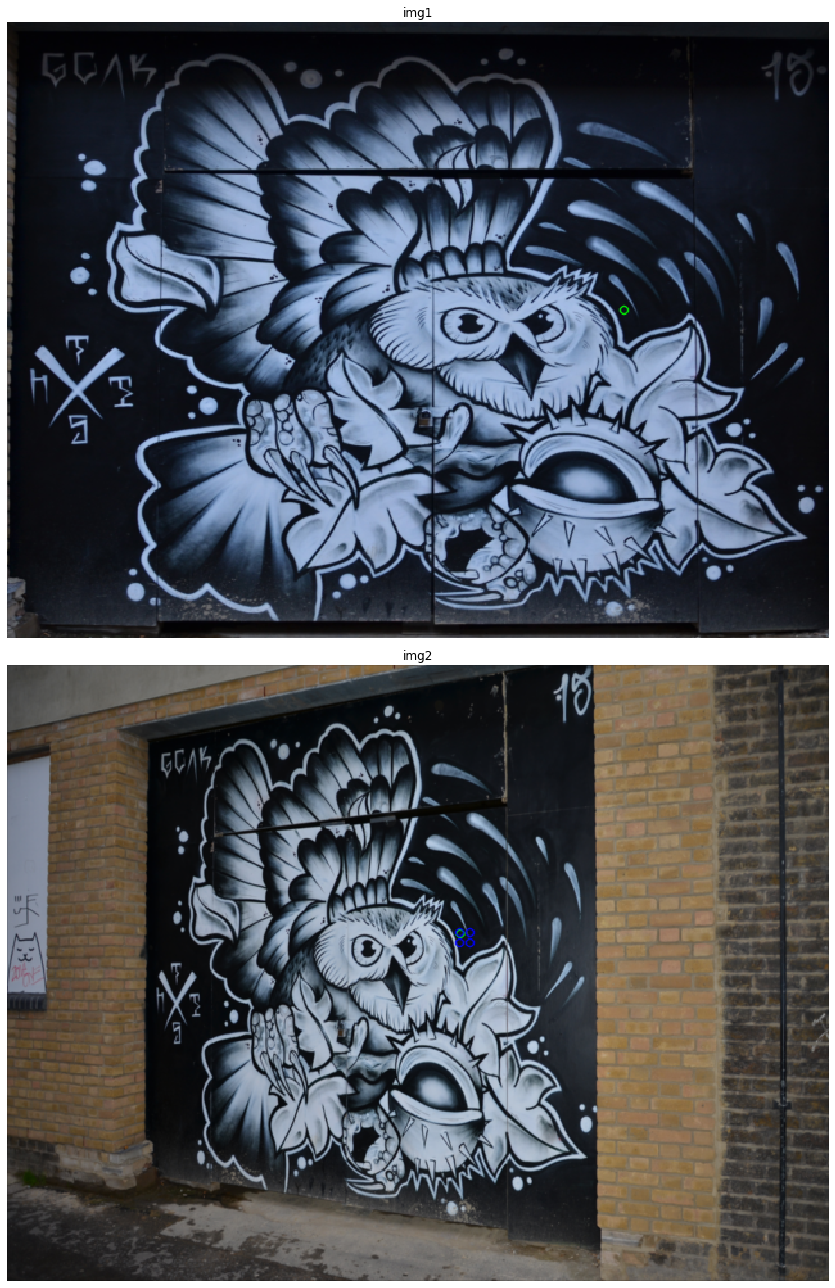

In [31]:
res_image1 = draw_cv_keypoints(cv_s_image1, image1_cell, (0, 255, 0))

res_image2 = draw_cv_keypoints(cv_s_image2, w_image1_cell, (0, 255, 0))
res_image2 = draw_cv_keypoints(res_image2, w_image1_cells, (0, 0, 255))

plot_figures({'img1': res_image1,
              'img2': res_image2}, 2, 1, (18, 18))

In [32]:
# SOS
sos_neg = 4

cells1_mask = torch.eye(coo_grid1.size(1)).repeat(b, 1, 1)

mask_ids = mask_ids.view(b, -1)

w_cell1_dist = calculate_difference_matrix(mask_ids, mask_ids)
w_cell1_mask = w_cell1_dist.eq(0).view(b, flat, 4, flat, 4).sum(-1).sum(-2).float()

cells1_sim  = calculate_inv_similarity_matrix(desc1, desc1)
cells1_sim = cells1_sim + cells1_mask * 5

w_cells1_sim = calculate_inv_similarity_matrix(w_desc1, w_desc1)
w_cells1_sim = w_cells_sim + w_cell1_mask * 5

_, cells1_neg_ids = cells1_sim.topk(k=sos_neg, dim=-1, largest=False)
_, w_cells1_neg_ids = w_cells1_sim.topk(k=sos_neg, dim=-1, largest=False)

cells1_neg_ids = cells1_neg_ids.view(b, flat * sos_neg).unsqueeze(-1).repeat(1, 1, c)
w_cells1_neg_ids = w_cells1_neg_ids.view(b, flat * sos_neg).unsqueeze(-1).repeat(1, 1, c)

cells1_neg_desc = desc1.gather(dim=1, index=cells1_neg_ids)
w_cells1_neg_desc = w_desc1.gather(dim=1, index=w_cells1_neg_ids)

desc1 = desc1.unsqueeze(2).repeat(1, 1, sos_neg, 1).view(b, flat * sos_neg, c)
w_desc1 = w_desc1.unsqueeze(2).repeat(1, 1, sos_neg, 1).view(b, flat * sos_neg, c)

sos = calculate_inv_similarity_vector(desc1, cells1_neg_desc) - calculate_inv_similarity_vector(w_desc1, w_cells1_neg_desc)

sos = (sos ** 2).view(b, flat, sos_neg).sum(-1).sqrt().mean()

print(sos)

tensor(0.2769)


In [33]:
w_image1_cell_mask = w_coo_grid1[0, w_cell1_mask[0, cell_id].nonzero()].squeeze(1)

In [34]:
res_image1 = draw_cv_keypoints(cv_s_image1, image1_cell, (0, 0, 255))

res_image2 = draw_cv_keypoints(cv_s_image2, w_image1_cell, (0, 0, 255))
res_image2 = draw_cv_keypoints(res_image2, w_image1_cells, (0, 0, 255))
res_image2 = draw_cv_keypoints(res_image2, w_image1_cell_mask, (255, 0, 255))


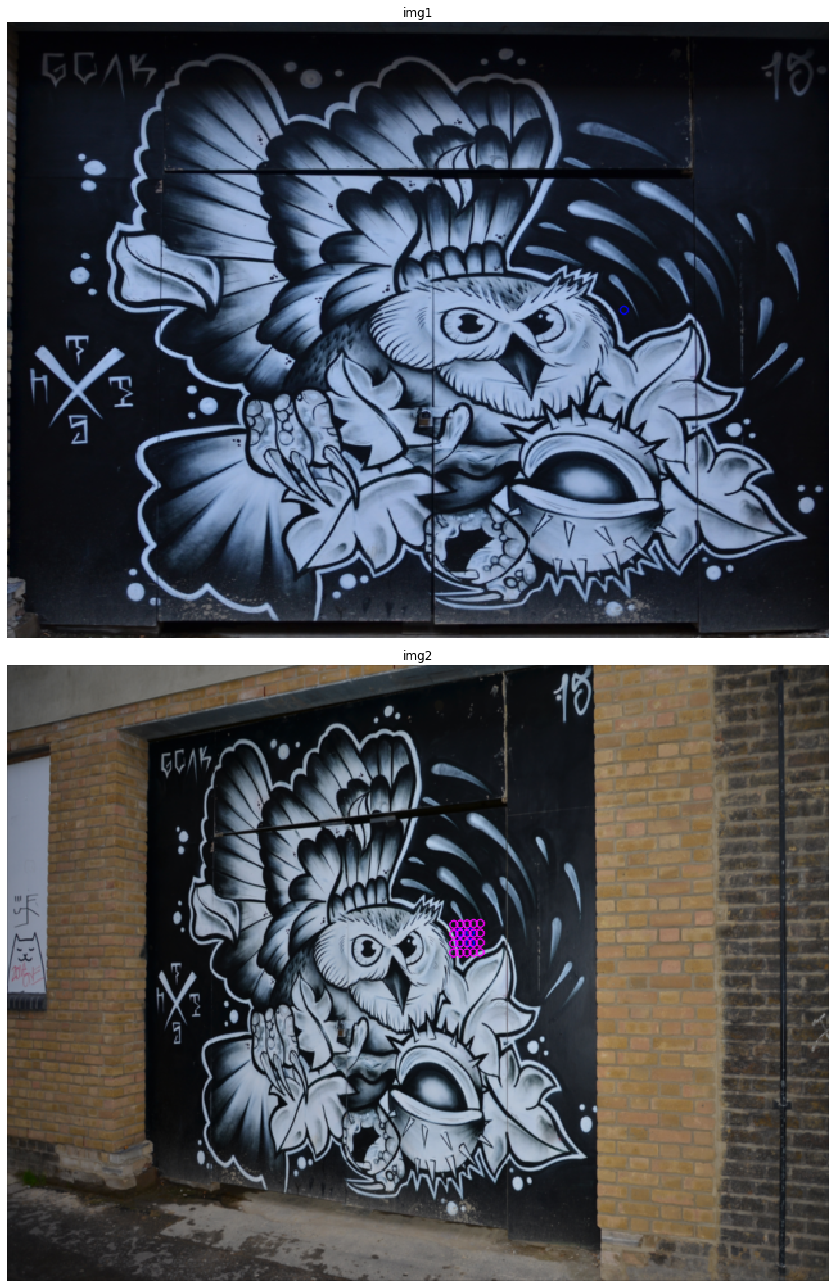

In [35]:
plot_figures({'img1': res_image1,
              'img2': res_image2}, 2, 1, (18, 18))